In [1]:
import os
import warnings
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import healpy as hp
from astropy.time import Time

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.data import get_data_dir

from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.site_models import ConstantSeeingData, ConstantWindData

from rubin_scheduler.utils import ra_dec2_hpid
from rubin_scheduler.scheduler.utils import empty_observation

from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.detailers import CameraSmallRotPerObservationListDetailer
from rubin_scheduler.scheduler.surveys import FieldSurvey
from rubin_scheduler.scheduler.schedulers import CoreScheduler, ComCamFilterSched
from rubin_scheduler.utils import Site, _approx_altaz2pa, pseudo_parallactic_angle, rotation_converter

from rubin_scheduler.scheduler import sim_runner

In [2]:
at_usdf = False
if at_usdf:
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/group/rubin/shared/rubin_sim_data"
print("Using rubin_sim_data from ", get_data_dir())

Using rubin_sim_data from  /Users/lynnej/rubin_sim_data


In [3]:
# Setting the start of the *survey* (and keeping this the same) is important for the Model Observatory and Scheduler,
# because this sets an overall dither pattern per night, but also helps track things that may 
# otherwise change per night ... for SV surveys, might not be totally necessary, but is good practice
# (you can change the *day* / mjd that you are simulating, of course, but mjd_start should remain the same)

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')

In [4]:
# Don't have to do this, but can grab almanac information

almanac = Almanac(mjd_start = survey_start.mjd)

def show_almanac_info(dayobs):
    night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
    
    dd = []
    for val, col in zip(night_info, night_info.dtype.names):
        if col == 'night':
            continue
        else:
            print(col, val, Time(val, format='mjd', scale='utc').iso)
    
    # And can check on the lunar phase -- this goes from 0 (new) to 100 (full)
    moon_phase = almanac.get_sun_moon_positions(night_info['moonrise'])['moon_phase']
    print(f'moonphase(%) {moon_phase.round(2)}')

show_almanac_info(dayobs)

sunset 60562.936555093154 2024-09-09 22:28:38.360
sun_n12_setting 60562.975207073614 2024-09-09 23:24:17.891
sun_n18_setting 60562.99454106344 2024-09-09 23:52:08.348
sun_n18_rising 60563.39397472935 2024-09-10 09:27:19.417
sun_n12_rising 60563.4132887749 2024-09-10 09:55:08.150
sunrise 60563.45188789442 2024-09-10 10:50:43.114
moonrise 60563.62073250674 2024-09-10 14:53:51.289
moonset 60563.19181374041 2024-09-10 04:36:12.707
moonphase(%) 46.25


In [5]:
def tma_movement(percent=70):
    # See https://confluence.lsstcorp.org/display/LSSTCOM/TMA+Motion+Settings
    # Expected performance at end of comcam on-sky is probably 10%
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    tma = {}
    scale = percent / 100.0
    tma['azimuth_maxspeed'] = np.min([10.0 * scale, 7.0])
    tma['azimuth_accel'] = 10.0 * scale
    tma['azimuth_jerk'] = np.max([1.0, 40.0 * scale])
    tma['altitude_maxspeed'] = 5.0 * scale
    tma['altitude_accel'] = 5.0 * scale
    tma['altitude_jerk'] = np.max([1.0, 20.0 * scale])
    tma['settle_time'] = 3.0
    return tma

In [6]:
def rotator_movement(percent=100):
    # Kevin and Brian say these can run 100% and are independent of TMA movement
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    rot = {}
    rot['maxspeed'] = 3.5 * percent/100
    rot['accel'] = 1.0 * percent/100
    rot['jerk'] = 4.0 * percent/100
    return rot

In [7]:
## field survey to be tested .. this should make it unnecessary to specify particular notes in features for basis functions.
# See examples of key basis functions .. you can call basis_function.__calc_rewards(conditions) to see what the basis function values look like.sv

In [8]:
def get_sv_fields():
    fields = (
        ("Rubin_SV_095_-25", 95., -25.), # High stellar densty, low extinction
        ("Rubin_SV_125_-15", 125., -15.), # High stellar densty, low extinction
        ("DESI_SV3_R1", 179.60, 0.000), # DESI, GAMA, HSC DR2, KiDS-N
        ("Rubin_SV_225_-40", 225., -40.), # 225 High stellar densty, low extinction
        ("DEEP_A0", 216, -12.5), # DEEP Solar Systen
        ("Rubin_SV_250_2", 250., 2.), # 250 High stellar densty, low extinction
        ("Rubin_SV_300_-41", 300., -41.), # High stellar densty, low extinction 
        ("Rubin_SV_280_-48", 280., -48.), # High stellar densty, low extinction 
        ("DEEP_B0", 310, -19), # DEEP Solar System
        ("ELAIS_S1", 9.45, -44.0), # ELAIS-S1 LSST DDF
        ("XMM_LSS", 35.708333, -4.75), # LSST DDF
        ("ECDFS", 53.125, -28.1), # ECDFS
        ("COSMOS", 150.1, 2.1819444444444445), # COSMOS
        ("EDFS_A", 58.9, -49.315), # EDFS_a
        ("EDFS_B", 63.6, -47.6), # EDFS_b
    )
    
    fields_dict = dict(zip([f[0] for f in fields], [{'RA': f[1], 'Dec': f[2]} for f in fields]))
    return fields_dict


def get_basis_functions_field_survey(
    nside: int = 32,
    wind_speed_maximum: float = 10,
) -> list[basis_functions.BaseBasisFunction]:
    """Get the basis functions for a field survey.

    Parameters
    ----------
    nside : `int`
        The nside value for the healpix grid.
    wind_speed_maximum : `float`
        Maximum wind speed tolerated for the observations of the survey,
        in m/s.

    Returns
    -------
    `list` of `basis_functions.BaseBasisFunction`
    """
    sun_alt_limit = -12.0
    moon_distance = 30

    bfs = [
        basis_functions.NotTwilightBasisFunction(sun_alt_limit=sun_alt_limit),
        basis_functions.MoonAvoidanceBasisFunction(nside=nside, moon_distance=moon_distance),
        basis_functions.AvoidDirectWind(
            wind_speed_maximum=wind_speed_maximum, nside=nside
        ),
        # Mask parts of the sky in alt/az, including parts of the sky that will move into this area
        # (replaces azimuth mask and zenith shadow mask, should also be able to replace airmass basis function)
        basis_functions.AltAzShadowMaskBasisFunction(
            nside=nside, min_alt=25, max_alt=85, min_az=0.0, max_az=360.0, shadow_minutes=50
        ),
        # Avoid revisits within 90 minutes -- sequence is about 60 minutes long, don't repeat immediately
        basis_functions.AvoidFastRevisitsBasisFunction(nside=nside, filtername=None, gap_min=90.0),
        # reward fields which are rising, but don't mask out after zenith
        basis_functions.RewardRisingBasisFunction(nside=nside, slope=0.1, penalty_val=0),
        # Reward parts of the sky which are darker -- note that this is only for r band, so relying on
        # skymap in r band .. if there isn't a strong reason to go with the darkest pointing,
        # it might be reasonable to just drop this basis function
        #basis_functions.M5DiffBasisFunction(filtername='r', nside=nside),
    ]
    return bfs

def get_field_survey(field_ra_deg, field_dec_deg, field_name, basis_functions, detailers, nside=32):
    
    field_survey = FieldSurvey(basis_functions, 
                                   field_ra_deg,
                                    field_dec_deg,
                                    sequence='ugrizy',
                                    nvisits={'u': 20, 'g': 20, 'r': 20, 'i': 20, 'z': 20, 'y': 20},
                                    exptimes={'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30},
                                    nexps={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
                                    ignore_obs=None,
                                    accept_obs=[field_name],
                                    survey_name=field_name,
                                    scheduler_note=None,
                                    readtime=2.4,
                                    filter_change_time=120.0,
                                    nside=nside,
                                    flush_pad=30.0,
                                    detailers=detailers)
    return field_survey

In [9]:
def prioritize_fields(priority_field_list=None, other_field_list=None):
    field_dict = get_sv_fields()
    tier1 = []
    if priority_field_list is not None:
        for f in priority_field_list:
            # Remember field name and remove from list
            if f in field_dict:
                tier1.append(f)
                del field_dict[f]
    tier2 = []
    if other_field_list is not None:
        for f in other_field_list:
            if f in field_dict:
                tier2.append(f)
                del field_dict[f]
    else:
        tier2 += list(field_dict.keys())
    return [tier1, tier2]


tiers = prioritize_fields() #prioritize_fields(['Rubin_SV_280_-48'], None)

print(tiers)

[[], ['Rubin_SV_095_-25', 'Rubin_SV_125_-15', 'DESI_SV3_R1', 'Rubin_SV_225_-40', 'DEEP_A0', 'Rubin_SV_250_2', 'Rubin_SV_300_-41', 'Rubin_SV_280_-48', 'DEEP_B0', 'ELAIS_S1', 'XMM_LSS', 'ECDFS', 'COSMOS', 'EDFS_A', 'EDFS_B']]


In [10]:
def get_model_observatory(dayobs='2024-09-09'):
    # Set up a fresh model observatory
    survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
    mjd_now = survey_start.mjd

    kinematic_model = KinemModel(mjd0=mjd_now)
    kinematic_model.setup_camera(readtime=2.4, **rotator_movement(100.))
    kinematic_model.setup_telescope(**tma_movement(10.0))
    
    # Some weather telemetry that might be useful
    seeing_data = ConstantSeeingData(fwhm_500=2.0)
    wind_data = ConstantWindData(wind_direction=340, wind_speed=5.0)
    
    # Set up the model observatory
    observatory = ModelObservatory(mjd=mjd_now, 
                                   mjd_start=survey_start.mjd,
                                   kinem_model=kinematic_model, # Modified kinematics
                                   cloud_data='ideal',          # No clouds
                                   seeing_data=seeing_data,     # Modified seeing
                                   wind_data=wind_data,         # Add some wind
                                   downtimes='ideal',           # No downtime
                                   lax_dome=True,               # dome crawl?
                                   init_load_length=1,          # size of skybrightness files to load first
                                  )
    return observatory

def get_comcam_schedulers(tiers=None):
    # Set up again to be sure all is 'clean'
    field_dict = get_sv_fields()
    if tiers is None:
        tiers = prioritize_fields() 
    
    surveys = []
    starting_tier = 0
    i = 0
    for t in tiers:
        if len(t) == 0:
            continue
        j = i + starting_tier
        i += 1
        surveys.append([])
        for kk, fieldname in enumerate(t):
            bfs = get_basis_functions_field_survey()
            detailer = CameraSmallRotPerObservationListDetailer(per_visit_rot=0.5)
            surveys[j].append(get_field_survey(field_dict[fieldname]['RA'], field_dict[fieldname]['Dec'], fieldname, bfs, [detailer]))
    surveys
    
    scheduler = CoreScheduler(surveys, nside=32)
    filter_scheduler = ComCamFilterSched()
    return scheduler, filter_scheduler


def update_model_observatory_sunset(observatory, filter_scheduler):
    # Make sure correct filters are mounted
    conditions = observatory.return_conditions()
    filters_needed = filter_scheduler(conditions)
    observatory.observatory.mount_filters(filters_needed)
    conditions = observatory.return_conditions()
    print("Current filter set", conditions.mounted_filters)
    
    # Move ahead to twilight
    observatory.mjd = conditions.sun_n18_setting
    print("Current observatory time", observatory.mjd)
    return observatory

In [11]:
new_observatory = get_model_observatory(dayobs)
scheduler, filter_scheduler = get_comcam_schedulers()
new_observatory = update_model_observatory_sunset(new_observatory, filter_scheduler)
conditions = new_observatory.return_conditions()
conditions.mjd, conditions.sun_n18_setting

Current filter set ['g', 'r', 'i']
Current observatory time 60562.99454106344


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


(60562.99454106344, 60562.99454106344)

In [13]:
verbose = False

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
mjd_now = survey_start.mjd

# Set up again to be sure all is 'clean'
scheduler, filter_scheduler = get_comcam_schedulers()
observatory = get_model_observatory(dayobs)
observatory = update_model_observatory_sunset(observatory, filter_scheduler)

# This is essentially sim_runner, but in a cell in steps

mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising

lsst = Site('LSST')
rc = rotation_converter('Rubin')

# Book keeping around timeskips and queue flushes
step_none = 15.0/60.0/24.0
counter = 0
mjd_last_flush = -1
nskip = 0

# Preallocate some "observations" 
start_result_size = int(1e4)
observations = empty_observation(n=start_result_size)

while mjd < mjd_end:
    # Are there observations on the queue that don't require checking conditions?
    # If so, skip update conditions. Otherwise update conditions.
    if not scheduler._check_queue_mjd_only(observatory.mjd):
        # Updating conditions for scheduler
        scheduler.update_conditions(observatory.return_conditions())
    # Request observations. This fills the queue.
    desired_obs = scheduler.request_observation(mjd=observatory.mjd)
    # If no observations requested, step into the future.
    if desired_obs is None:
        warnings.warn("No observation requested. Step into the future and trying again.")
        observatory.mjd = observatory.mjd + step_none
        scheduler.update_conditions(observatory.return_conditions())
        nskip += 1
        continue
    # Otherwise, acquire those observations - this steps observatory time forward to end of obs.
    completed_obs, new_night = observatory.observe(desired_obs)
    
    # Observations can fail (be rejected as out of bounds, etc.)
    if completed_obs is not None:
        # Add observations back to the surveys and features
        scheduler.add_observation(completed_obs[0])
        observations[counter] = completed_obs[0]
        # Add observations back to the filter scheduler (many don't care, nullop)
        filter_scheduler.add_observation(completed_obs[0])
        counter += 1
        if counter == observations.size:
            add_observations = empty_observation(n=append_result_size)
            observations = np.concatenate([observations, add_observations])

    else:
        # An observation failed to execute, usually it was outside
        # the altitude limits.
        if observatory.mjd == mjd_last_flush:
            raise RuntimeError("Scheduler has failed to provide a valid observation multiple times.")
        # if this is a first offence, might just be that targets set.
        # Flush queue and get some new targets.
        scheduler.flush_queue()
        mjd_last_flush = observatory.mjd + 0
    
    if new_night:
        # Change filters if needed.
        conditions = observatory.return_conditions()
        filters_needed = filter_scheduler(conditions)
        observatory.observatory.mount_filters(filters_needed)

    mjd = observatory.mjd + 0
    if verbose:
        if (mjd - mjd_track) > step:
            progress = np.max((mjd - mjd_start) / mjd_run * 100)
            text = "\rprogress = %.2f%%" % progress
            sys.stdout.write(text)
            sys.stdout.flush()
            mjd_track = mjd + 0


# Clean up observations - get better parallactic angle 
# And recompute rot tel pos from rotSkyPos and pseudo-para angle.
# (in operations, this "just happens" in the telescope CSC). 
# trim off any observations that were pre-allocated but not used
observations = observations[0:counter]
# Using pseudo_parallactic_angle, see https://smtn-019.lsst.io/v/DM-44258/index.html
pa, alt, az = pseudo_parallactic_angle(
    np.degrees(observations["RA"]),
    np.degrees(observations["dec"]),
    observations["mjd"],
    lon=lsst.longitude,
    lat=lsst.latitude,
    height=lsst.height,
)
observations["alt"] = np.radians(alt)
observations["az"] = np.radians(az)
observations["psudo_pa"] = np.radians(pa)
observations["rotTelPos"] = rc._rotskypos2rottelpos(observations["rotSkyPos"], observations["psudo_pa"])
# Also include traditional parallactic angle
pa = _approx_altaz2pa(observations["alt"], observations["az"], lsst.latitude_rad)
observations["pa"] = pa


Current filter set ['g', 'r', 'i']
Current observatory time 60562.99454106344


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:289: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:291: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(rewards) > -np.inf:
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:294: RuntimeWarning: All-NaN slice encountered
  if (np.nanmax(rewards) == -np.inf) | (np.isnan(np.nanmax(rewards))):
Failed to fill queue at time [60563.0653021]
/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_81474/4212304355.py:40: UserWarning: No observation requested. Step into the future and trying again.
  warnings.warn("No observation requested. Step into the future and trying again.")
Failed to fill queue at time [60563.07571877]
Failed to fill queue at time [60563.08613544]
Failed to fil

In [17]:
# We see that the time is well before sunrise, and the surveys are requesting an observation .. but the observation is not valid
conditions = observatory.return_conditions()
desired_obs[0]['note'], completed_obs, len(scheduler.queue), conditions.mjd, conditions.sun_n18_rising, conditions.sun_n12_rising

('ECDFS',
 None,
 0,
 array([60563.97557348]),
 array([60564.39310964]),
 array([60564.41243321]))

In [15]:
observatory.mjd
print("Check each of these field surveys at the time of conditions")
print("Time", observatory.mjd)

df = []
for s in scheduler.survey_lists[0]:
    reward = s.calc_reward_function(conditions)
    field_alt = conditions.alt[s.indx]
    obs = s.generate_observations(conditions)
    df.append([s.survey_name, s.extra_features['ObsRecord'](), reward, np.degrees(field_alt)])
pd.DataFrame(df, columns=['target', 'nobs recorded', 'current reward', 'field alt'])

Check each of these field surveys at the time of conditions
Time [60563.97557348]


,target,nobs recorded,current reward,field alt
0,Rubin_SV_095_-25,60,NaN,-35.041273
1,Rubin_SV_125_-15,0,NaN,-34.454961
2,DESI_SV3_R1,0,NaN,-2.026760
3,Rubin_SV_225_-40,0,NaN,51.624869
4,DEEP_A0,0,NaN,35.454341
5,Rubin_SV_250_2,0,NaN,52.923615
6,Rubin_SV_300_-41,121,0.385078,64.312933
7,Rubin_SV_280_-48,2,NaN,70.442120
8,DEEP_B0,16,-1.860060,52.492293
9,ELAIS_S1,180,NaN,14.214353


In [ ]:
# the EDFS_A is "the winner" and is the desired observation .. but the field altitude is quite low. 
# Can we find out why it's being rejected? 
s = scheduler.survey_lists[0][13]
conditions = observatory.return_conditions()
print('desired obs', desired_obs[0]['filter'], conditions.mounted_filters)
slewtime, visittime = observatory.observatory.observe(
            desired_obs[0],
            observatory.mjd,
            rot_tel_pos=desired_obs[0]["rotTelPos"],
            lax_dome=observatory.lax_dome,
        )
print(np.degrees(conditions.alt[s.indx]), np.degrees(conditions.az[s.indx]), np.degrees(s.dec))
alt_rad, az_rad, pa = observatory.observatory.radec2altaz(s.ra, s.dec, observatory.mjd)
print(np.degrees(alt_rad), np.degrees(az_rad))
# Okay -- so, the kinematic model does a more accurate calculation of alt/az, at the exact ra/dec, for the pointing
# the field survey just uses the healpixel and the values can be slightly incorrect.
# maybe we just add a bit of buffer to the altazshadow mask. 

In [18]:
oo = pd.DataFrame(observations)
oo.groupby('target')['target'].count()

target
DEEP_B0              16
ECDFS                18
EDFS_A              180
EDFS_B               73
ELAIS_S1            180
Rubin_SV_095_-25     60
Rubin_SV_280_-48      2
Rubin_SV_300_-41    121
XMM_LSS              61
Name: target, dtype: int64

In [ ]:
"""
# The function sim_runner modifies the observatory
# Change the date of what is RUNNING (what night) by changing time in the observatory
# Leave the start of the observatory running at survey_start
dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
mjd_now = survey_start.mjd

# Set up again to be sure all is 'clean'
scheduler, filter_scheduler = get_comcam_schedulers()
observatory = get_model_observatory(dayobs)

observatory, scheduler, observations = sim_runner(observatory, scheduler, 
                                                 filter_scheduler=filter_scheduler,
                                                 mjd_start=survey_start.mjd,
                                                 survey_length=1, verbose=False)
"""                                                 

In [19]:
from rubin_scheduler.scheduler.utils import SchemaConverter

In [20]:
sc = SchemaConverter()
visits = sc.obs2opsim(observations)

In [21]:
visits.head()

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
0,0,300.0,-41.0,60562.996467,60596.402041,30.0,r,202.476622,0.0,2,...,264.645014,168.444478,4.963012,239.445801,-24.917733,52.201432,123.746098,41.703990,126.171038,0
1,1,300.0,-41.0,60562.996893,60596.402041,30.0,r,203.162937,0.0,2,...,264.563333,168.444860,4.962851,239.449570,-24.918508,52.198158,123.745721,41.705708,126.171038,0
2,2,300.0,-41.0,60562.997319,60596.402041,30.0,r,202.885841,0.0,2,...,264.481546,168.445243,4.962690,239.453343,-24.919282,52.194883,123.745343,41.707428,126.171038,0
3,3,300.0,-41.0,60562.997745,60596.402041,30.0,r,202.610510,0.0,2,...,264.399650,168.445626,4.962528,239.457120,-24.920053,52.191606,123.744966,41.709149,126.171038,0
4,4,300.0,-41.0,60562.998171,60596.402041,30.0,r,202.336971,0.0,2,...,264.317648,168.446008,4.962367,239.460901,-24.920822,52.188327,123.744589,41.710872,126.171038,0


In [22]:
import rubin_sim.maf as maf

In [23]:
m = maf.CountMetric(col='observationStartMJD')
s = maf.HealpixSlicer(64)
bundle = maf.MetricBundle(m, s, "")

visits_np = visits.to_records()  # MAF does need a np.ndarray
out_dir='test'
g = maf.MetricBundleGroup({'0': bundle}, None, out_dir=out_dir)
g.run_current('', sim_data=visits_np)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

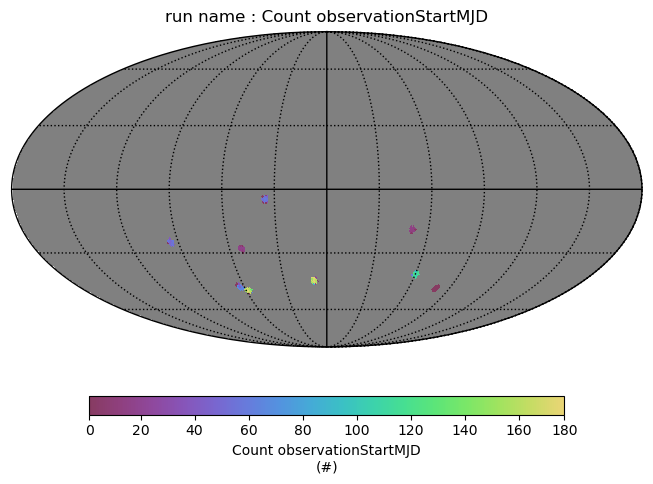

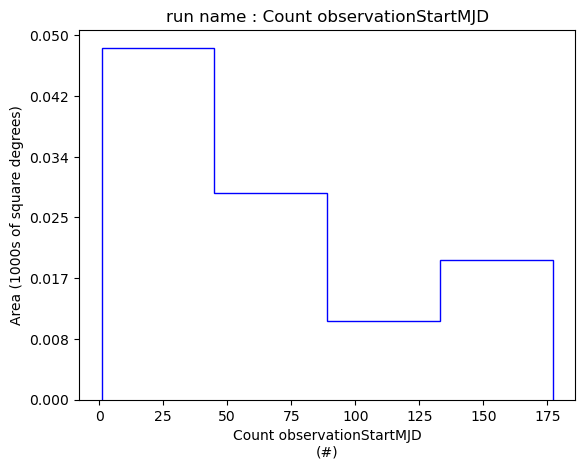

In [24]:
bundle.plot()

In [25]:
visits.groupby('target')['observationStartMJD'].count()

target
DEEP_B0              16
ECDFS                18
EDFS_A              180
EDFS_B               73
ELAIS_S1            180
Rubin_SV_095_-25     60
Rubin_SV_280_-48      2
Rubin_SV_300_-41    121
XMM_LSS              61
Name: observationStartMJD, dtype: int64

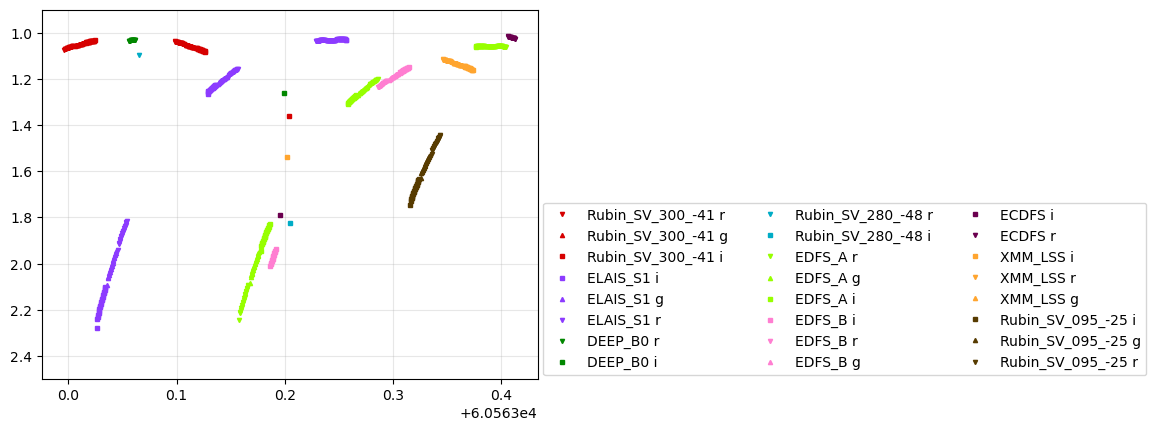

In [29]:
plt.figure()
filtershapes = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
filtercolors = {'u': '#005BDB',
                'g': '#3DA952',
                'r': '#c61c00',
                'i': '#997500',
                'z': '#CE0D77',
                'y': '#5d0000'}
fieldcolors = {}
for i, t in enumerate(visits.target.unique()):
    fieldcolors[t] = cc.glasbey[i]

nvisits = visits.query('night ==1')
for t in nvisits.target.unique():
    vv = nvisits.query('target == @t')
    for f in vv['filter'].unique():
        vvf = vv.query('filter == @f')
        label = f'{t} {f}'
        plt.plot(vvf.observationStartMJD, vvf.airmass, linestyle='', 
                 marker=filtershapes[f], markersize=3, color=fieldcolors[t], label=label)
plt.legend(loc=(1.01,0.01), ncols=3)
plt.ylim(2.5, 0.9)
plt.grid(alpha=0.3)

In [27]:
visits['filter'].unique()

array(['r', 'g', 'i'], dtype=object)